In [7]:
import numpy as np
import matplotlib.pyplot as plt

from math import log10

In [8]:
plot_precision = 1000

data_size = 100

n_satellites = 10

stride = 0.001
phi_min = stride
phi_max = 1.6

config = {
    "base": {
        "obdh": {
            "speed": 30.0,
            "phi": 0.9,
            "energy_uptime": 1,
            "energy_io": 0.001
        },
        "ground_link": {
            "speed": 10.0,
            "energy": 5,
            "distance": 700
        }
    },
    "offloading": {
        "user_satellite": {
            "obdh": {  # No computing on the user satellite in this scenario
                "phi": None,
                "speed": None,
                "energy_uptime": None,
                "energy_io": None
            },
            "isl": {
                "speed": None,  # Exploring ISL speed variation
                "energy": 3,
                "distance": 100
            }
        },
        "edge_node": {
            "edge_computer": {
                "phi": None,  # Exploring EC phi variation
                "speed": 300.0,
                "energy_uptime": 50,
                "energy_io": 0.001
            },
            "ground_link": {
                "speed": None,  # Exploring GL speed variation
                "energy": 5,
                "distance": 700
            }
        }
    }
}

s_gl = config['base']['ground_link']['speed']

In [9]:
def processing_time_cost(d_in, speed):
    return d_in / speed

def processing_energy_cost(d_in, speed, energy_uptime, energy_io):
    return (energy_io * d_in) + (energy_uptime * (d_in / speed))

def process_data_quadratic(d_in, phi):
    return d_in * phi

def process_data_linear(d_in, tau):
    return d_in + tau

def transmission_time_cost(d_in, speed):
    return d_in / speed

def transmission_energy_cost(d_in, speed, energy, distance):
    return log10(distance) * energy * (d_in / speed)

In [10]:
base_t_obdh = processing_time_cost(data_size, config['base']['obdh']['speed'])
base_e_obdh = processing_energy_cost(data_size, config['base']['obdh']['speed'], config['base']['obdh']['energy_uptime'], config['base']['obdh']['energy_io'])
d_out = process_data_quadratic(data_size, config['base']['obdh']['phi'])

base_t_gl = transmission_time_cost(d_out, config['base']['ground_link']['speed'])
base_e_gl = transmission_energy_cost(d_out, config['base']['ground_link']['speed'], config['base']['ground_link']['energy'], config['base']['ground_link']['distance'])

base_time_cost = base_t_obdh + base_t_gl
base_energy_cost = base_e_obdh + base_e_gl

print("Base time cost: ", base_time_cost, "Base energy cost: ", base_energy_cost)

Base time cost:  12.333333333333334 Base energy cost:  131.4627451339749


In [11]:
n_satellites_values = range(1, n_satellites, 1)
phi_values = np.arange(phi_min, phi_max, stride)
isl_ratio_values = np.logspace(-0.4, 2, plot_precision)

quadratic_results = {}

for i, n in enumerate(n_satellites_values):
    quadratic_results[n] = {}

    for ratio_idx, isl_ratio in enumerate(isl_ratio_values):
        quadratic_results[n][isl_ratio] = {}
        s_isl = s_gl * isl_ratio

        first_transmission_time_cost = transmission_time_cost(data_size, s_isl)
        first_transmission_energy_cost = transmission_energy_cost(
            data_size,
            s_isl,
            config['offloading']['user_satellite']['isl']['energy'],
            config['offloading']['user_satellite']['isl']['distance'])

        for phi_en_original in phi_values:
            d_out = data_size

            iteration_time_cost = first_transmission_time_cost
            iteration_energy_cost = first_transmission_energy_cost

            if n == 1:
                iteration_time_cost += processing_time_cost(d_out, config['offloading']['edge_node']['edge_computer']['speed'])
                iteration_energy_cost += processing_energy_cost(
                d_out,
                config['offloading']['edge_node']['edge_computer']['speed'],
                config['offloading']['edge_node']['edge_computer']['energy_uptime'],
                config['offloading']['edge_node']['edge_computer']['energy_io'])

                d_out = process_data_quadratic(d_out, phi_en_original)

            else:
                phi_en_computed = (phi_en_original ** (1/n))

                for sat_id in range(1, n+1, 1):
                    iteration_time_cost += processing_time_cost(d_out, config['offloading']['edge_node']['edge_computer']['speed'])
                    iteration_energy_cost += processing_energy_cost(
                    d_out,
                    config['offloading']['edge_node']['edge_computer']['speed'],
                    config['offloading']['edge_node']['edge_computer']['energy_uptime'],
                    config['offloading']['edge_node']['edge_computer']['energy_io'])

                    d_out = process_data_quadratic(d_out, phi_en_computed)

                    if sat_id != n:
                        iteration_time_cost += transmission_time_cost(d_out, s_isl)
                        iteration_energy_cost += transmission_energy_cost(
                            d_out,
                            s_isl,
                            config['offloading']['user_satellite']['isl']['energy'],
                            config['offloading']['user_satellite']['isl']['distance'])

            iteration_time_cost += transmission_time_cost(d_out, config['base']['ground_link']['speed'])
            iteration_energy_cost += transmission_energy_cost(
            d_out,
            config['base']['ground_link']['speed'],
            config['base']['ground_link']['energy'],
            config['base']['ground_link']['distance'])

            quadratic_results[n][isl_ratio][phi_en_original] = (iteration_time_cost, iteration_energy_cost)

        if ratio_idx % 15 == 0:
            print(f"  Progress: {ratio_idx + 1}/{len(isl_ratio_values)} ISL ratios completed")

print("\nGrid computation complete!")

Processing n= 1 , ratio= 0.3981071705534972
  Progress: 1/1000 ISL ratios completed
Processing n= 1 , ratio= 0.4003154966115263
Processing n= 1 , ratio= 0.40253607239610967
Processing n= 1 , ratio= 0.40476896585726757
Processing n= 1 , ratio= 0.40701424532194375
Processing n= 1 , ratio= 0.4092719794960955
Processing n= 1 , ratio= 0.4115422374667967
Processing n= 1 , ratio= 0.4138250887043515
Processing n= 1 , ratio= 0.41612060306442056
Processing n= 1 , ratio= 0.4184288507901581
Processing n= 1 , ratio= 0.4207499025143619
Processing n= 1 , ratio= 0.42308382926163407
Processing n= 1 , ratio= 0.42543070245055503
Processing n= 1 , ratio= 0.42779059389586854
Processing n= 1 , ratio= 0.43016357581067943
Processing n= 1 , ratio= 0.4325497208086632
  Progress: 16/1000 ISL ratios completed
Processing n= 1 , ratio= 0.434949101906288
Processing n= 1 , ratio= 0.43736179252504925
Processing n= 1 , ratio= 0.4397878664937159
Processing n= 1 , ratio= 0.4422273980505899
Processing n= 1 , ratio= 0.4446

In [12]:
n_satellites_values = range(1, n_satellites, 1)
phi_values = np.arange(phi_min, phi_max, stride)
isl_ratio_values = np.logspace(-0.4, 2, plot_precision)

linear_results = {}

for i, n in enumerate(n_satellites_values):
    linear_results[n] = {}

    for ratio_idx, isl_ratio in enumerate(isl_ratio_values):
        linear_results[n][isl_ratio] = {}
        s_isl = s_gl * isl_ratio

        first_transmission_time_cost = transmission_time_cost(data_size, s_isl)
        first_transmission_energy_cost = transmission_energy_cost(
            data_size,
            s_isl,
            config['offloading']['user_satellite']['isl']['energy'],
            config['offloading']['user_satellite']['isl']['distance'])

        for phi_en_original in phi_values:
            final_data_size = data_size * phi_en_original
            diff = final_data_size - data_size

            tau = diff / n

            d_out = data_size

            iteration_time_cost = first_transmission_time_cost
            iteration_energy_cost = first_transmission_energy_cost

            if n == 1:
                iteration_time_cost += processing_time_cost(d_out, config['offloading']['edge_node']['edge_computer']['speed'])
                iteration_energy_cost += processing_energy_cost(
                d_out,
                config['offloading']['edge_node']['edge_computer']['speed'],
                config['offloading']['edge_node']['edge_computer']['energy_uptime'],
                config['offloading']['edge_node']['edge_computer']['energy_io'])

                d_out = process_data_linear(d_out, tau)

            else:
                phi_en_computed = (phi_en_original ** (1/n))

                for sat_id in range(1, n+1, 1):
                    iteration_time_cost += processing_time_cost(d_out, config['offloading']['edge_node']['edge_computer']['speed'])
                    iteration_energy_cost += processing_energy_cost(
                    d_out,
                    config['offloading']['edge_node']['edge_computer']['speed'],
                    config['offloading']['edge_node']['edge_computer']['energy_uptime'],
                    config['offloading']['edge_node']['edge_computer']['energy_io'])

                    d_out = process_data_linear(d_out, tau)

                    if sat_id != n:
                        iteration_time_cost += transmission_time_cost(d_out, s_isl)
                        iteration_energy_cost += transmission_energy_cost(
                            d_out,
                            s_isl,
                            config['offloading']['user_satellite']['isl']['energy'],
                            config['offloading']['user_satellite']['isl']['distance'])

            iteration_time_cost += transmission_time_cost(d_out, config['base']['ground_link']['speed'])
            iteration_energy_cost += transmission_energy_cost(
            d_out,
            config['base']['ground_link']['speed'],
            config['base']['ground_link']['energy'],
            config['base']['ground_link']['distance'])

            linear_results[n][isl_ratio][phi_en_original] = (iteration_time_cost, iteration_energy_cost)

        if ratio_idx % 15 == 0:
            print(f"  Progress: {ratio_idx + 1}/{len(isl_ratio_values)} ISL ratios completed")

print("\nGrid computation complete!")

Processing n= 1 , ratio= 0.3981071705534972
  Progress: 1/1000 ISL ratios completed
Processing n= 1 , ratio= 0.4003154966115263
Processing n= 1 , ratio= 0.40253607239610967
Processing n= 1 , ratio= 0.40476896585726757
Processing n= 1 , ratio= 0.40701424532194375
Processing n= 1 , ratio= 0.4092719794960955
Processing n= 1 , ratio= 0.4115422374667967
Processing n= 1 , ratio= 0.4138250887043515
Processing n= 1 , ratio= 0.41612060306442056
Processing n= 1 , ratio= 0.4184288507901581
Processing n= 1 , ratio= 0.4207499025143619
Processing n= 1 , ratio= 0.42308382926163407
Processing n= 1 , ratio= 0.42543070245055503
Processing n= 1 , ratio= 0.42779059389586854
Processing n= 1 , ratio= 0.43016357581067943
Processing n= 1 , ratio= 0.4325497208086632
  Progress: 16/1000 ISL ratios completed
Processing n= 1 , ratio= 0.434949101906288
Processing n= 1 , ratio= 0.43736179252504925
Processing n= 1 , ratio= 0.4397878664937159
Processing n= 1 , ratio= 0.4422273980505899
Processing n= 1 , ratio= 0.4446

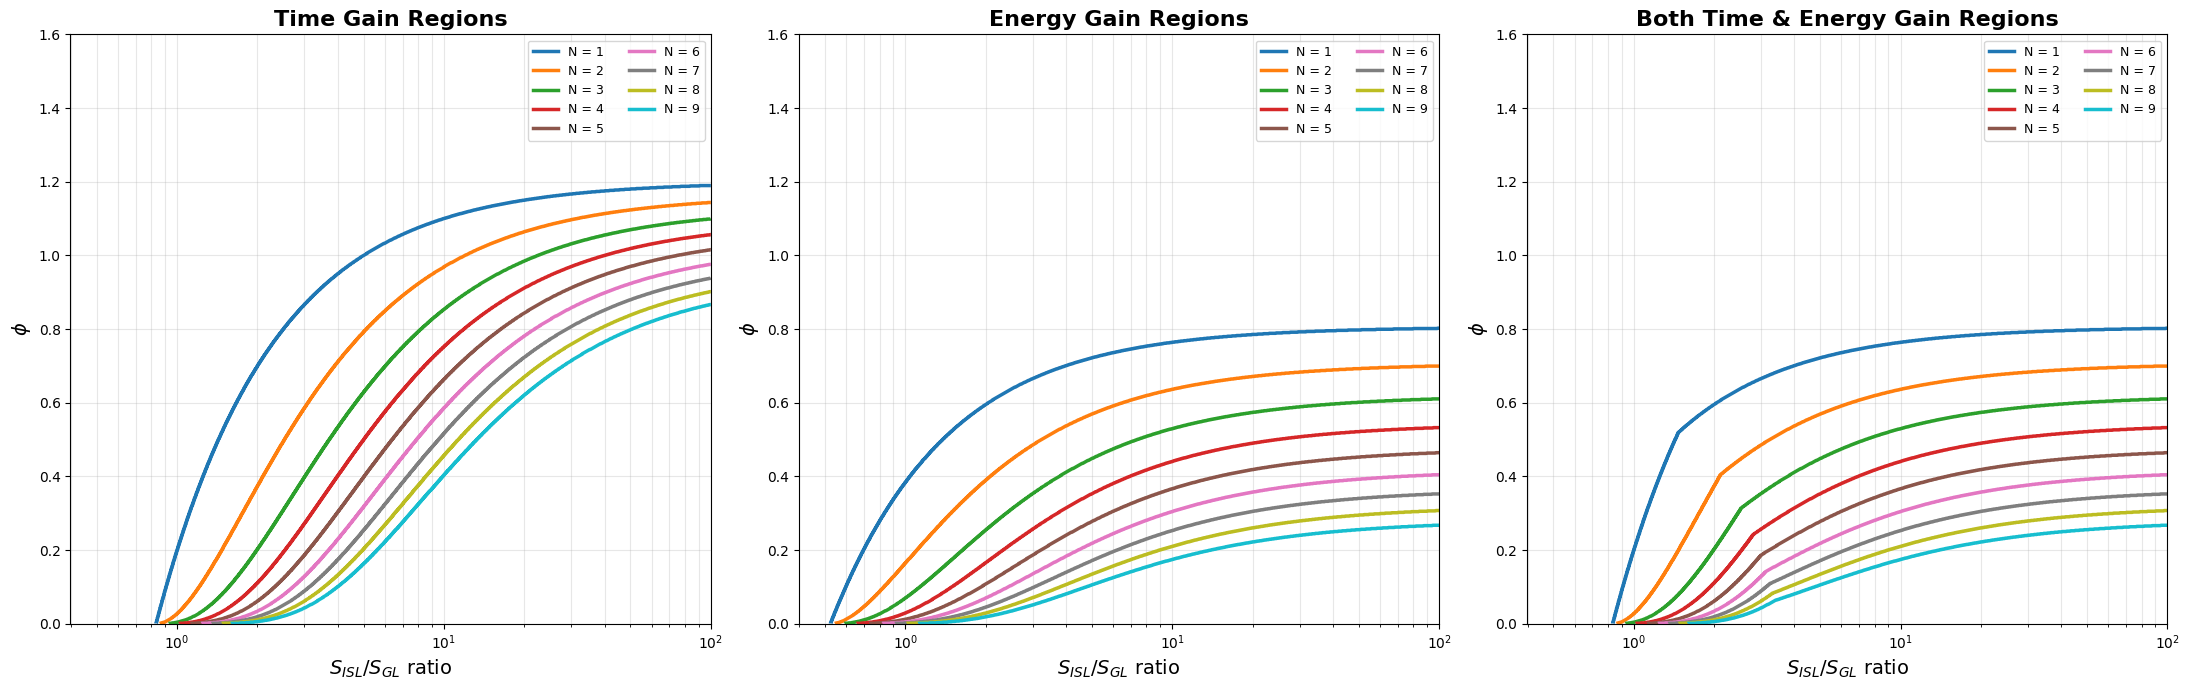

In [13]:
gain_maps = {}

for n in n_satellites_values:
    # Create 2D arrays: rows = phi values, columns = isl_ratio values
    time_gain_map = np.zeros((len(phi_values), len(isl_ratio_values)))
    energy_gain_map = np.zeros((len(phi_values), len(isl_ratio_values)))
    both_gain_map = np.zeros((len(phi_values), len(isl_ratio_values)))

    for i, phi_en in enumerate(phi_values):
        for j, isl_ratio in enumerate(isl_ratio_values):
            time_cost, energy_cost = quadratic_results[n][isl_ratio][phi_en]

            # Mark gains
            if time_cost < base_time_cost:
                time_gain_map[i, j] = 1

            if energy_cost < base_energy_cost:
                energy_gain_map[i, j] = 1

            if time_cost < base_time_cost and energy_cost < base_energy_cost:
                both_gain_map[i, j] = 1

    gain_maps[n] = {
        'time': time_gain_map,
        'energy': energy_gain_map,
        'both': both_gain_map
    }

# Plot combined gain regions with outlines only
# Three plots: Time Gain, Energy Gain, Both Gains
# Each plot shows outlines for all n_satellites values

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 7))

# Create meshgrid for contour plots
X, Y = np.meshgrid(isl_ratio_values, phi_values)

# Define colors for different n_satellites
colors = plt.cm.tab10(np.linspace(0, 1, len(n_satellites_values)))

# Plot 1: Time Gain - All N satellites
for idx, n in enumerate(n_satellites_values):
    time_map = gain_maps[n]['time']
    # Only plot the contour outline at level 0.5
    contour = ax1.contour(X, Y, time_map, levels=[0.5],
                          colors=[colors[idx]], linewidths=2.5,
                          linestyles='solid')

ax1.set_xscale('log')
ax1.set_xlabel(r'$S_{ISL} / S_{GL}$ ratio', fontsize=14)
ax1.set_ylabel(r'$\phi$', fontsize=14)
ax1.set_title('Time Gain Regions', fontsize=16, fontweight='bold')
ax1.grid(True, alpha=0.3, which='both')
ax1.set_ylim([0, phi_max])

# Create legend
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], color=colors[idx], linewidth=2.5, label=f'N = {n}')
                   for idx, n in enumerate(n_satellites_values)]
ax1.legend(handles=legend_elements, loc='upper right', fontsize=9, ncol=2)

# Plot 2: Energy Gain - All N satellites
for idx, n in enumerate(n_satellites_values):
    energy_map = gain_maps[n]['energy']
    # Only plot the contour outline at level 0.5
    contour = ax2.contour(X, Y, energy_map, levels=[0.5],
                          colors=[colors[idx]], linewidths=2.5,
                          linestyles='solid')

ax2.set_xscale('log')
ax2.set_xlabel(r'$S_{ISL} / S_{GL}$ ratio', fontsize=14)
ax2.set_ylabel(r'$\phi$', fontsize=14)
ax2.set_title('Energy Gain Regions', fontsize=16, fontweight='bold')
ax2.grid(True, alpha=0.3, which='both')
ax2.set_ylim([0, phi_max])

# Create legend
legend_elements = [Line2D([0], [0], color=colors[idx], linewidth=2.5, label=f'N = {n}')
                   for idx, n in enumerate(n_satellites_values)]
ax2.legend(handles=legend_elements, loc='upper right', fontsize=9, ncol=2)

# Plot 3: Both Gains - All N satellites
for idx, n in enumerate(n_satellites_values):
    both_map = gain_maps[n]['both']
    # Only plot the contour outline at level 0.5
    contour = ax3.contour(X, Y, both_map, levels=[0.5],
                          colors=[colors[idx]], linewidths=2.5,
                          linestyles='solid')

ax3.set_xscale('log')
ax3.set_xlabel(r'$S_{ISL} / S_{GL}$ ratio', fontsize=14)
ax3.set_ylabel(r'$\phi$', fontsize=14)
ax3.set_title('Both Time & Energy Gain Regions', fontsize=16, fontweight='bold')
ax3.grid(True, alpha=0.3, which='both')
ax3.set_ylim([0, phi_max])

# Create legend
legend_elements = [Line2D([0], [0], color=colors[idx], linewidth=2.5, label=f'N = {n}')
                   for idx, n in enumerate(n_satellites_values)]
ax3.legend(handles=legend_elements, loc='upper right', fontsize=9, ncol=2)

plt.tight_layout()
plt.show()

for n in n_satellites_values:
    time_map = gain_maps[n]['time']
    energy_map = gain_maps[n]['energy']
    both_map = gain_maps[n]['both']

    time_gain_pct = 100 * np.sum(time_map) / time_map.size
    energy_gain_pct = 100 * np.sum(energy_map) / energy_map.size
    both_gain_pct = 100 * np.sum(both_map) / both_map.size

Creating gain region maps...
Gain region maps created!


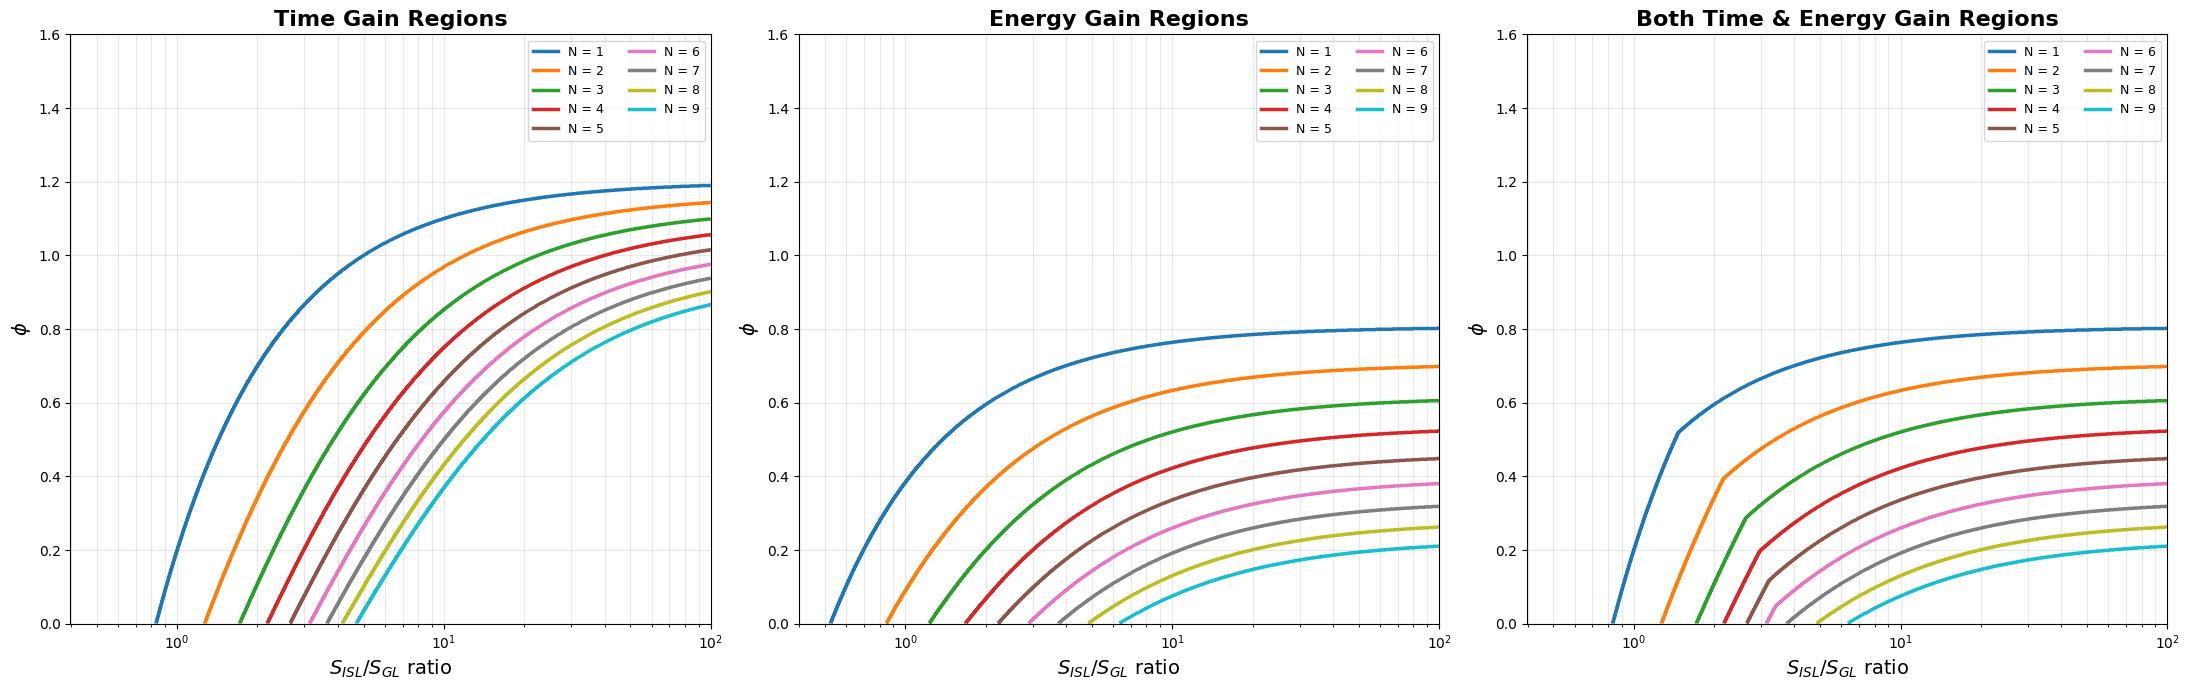


=== Summary Statistics ===

N = 1 satellites:
  Time gain region: 51.5% of parameter space
  Energy gain region: 38.8% of parameter space
  Both gains region: 37.1% of parameter space

N = 2 satellites:
  Time gain region: 42.3% of parameter space
  Energy gain region: 29.3% of parameter space
  Both gains region: 28.2% of parameter space

N = 3 satellites:
  Time gain region: 36.4% of parameter space
  Energy gain region: 22.8% of parameter space
  Both gains region: 22.2% of parameter space

N = 4 satellites:
  Time gain region: 32.1% of parameter space
  Energy gain region: 17.9% of parameter space
  Both gains region: 17.6% of parameter space

N = 5 satellites:
  Time gain region: 28.6% of parameter space
  Energy gain region: 14.1% of parameter space
  Both gains region: 13.9% of parameter space

N = 6 satellites:
  Time gain region: 25.8% of parameter space
  Energy gain region: 10.9% of parameter space
  Both gains region: 10.9% of parameter space

N = 7 satellites:
  Time gain

In [14]:
print("Creating gain region maps...")

gain_maps = {}

for n in n_satellites_values:
    # Create 2D arrays: rows = phi values, columns = isl_ratio values
    time_gain_map = np.zeros((len(phi_values), len(isl_ratio_values)))
    energy_gain_map = np.zeros((len(phi_values), len(isl_ratio_values)))
    both_gain_map = np.zeros((len(phi_values), len(isl_ratio_values)))

    for i, phi_en in enumerate(phi_values):
        for j, isl_ratio in enumerate(isl_ratio_values):
            time_cost, energy_cost = linear_results[n][isl_ratio][phi_en]

            # Mark gains
            if time_cost < base_time_cost:
                time_gain_map[i, j] = 1

            if energy_cost < base_energy_cost:
                energy_gain_map[i, j] = 1

            if time_cost < base_time_cost and energy_cost < base_energy_cost:
                both_gain_map[i, j] = 1

    gain_maps[n] = {
        'time': time_gain_map,
        'energy': energy_gain_map,
        'both': both_gain_map
    }

print("Gain region maps created!")

# Plot combined gain regions with outlines only
# Three plots: Time Gain, Energy Gain, Both Gains
# Each plot shows outlines for all n_satellites values

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 7))

# Create meshgrid for contour plots
X, Y = np.meshgrid(isl_ratio_values, phi_values)

# Define colors for different n_satellites
colors = plt.cm.tab10(np.linspace(0, 1, len(n_satellites_values)))

# Plot 1: Time Gain - All N satellites
for idx, n in enumerate(n_satellites_values):
    time_map = gain_maps[n]['time']
    # Only plot the contour outline at level 0.5
    contour = ax1.contour(X, Y, time_map, levels=[0.5],
                          colors=[colors[idx]], linewidths=2.5,
                          linestyles='solid')

ax1.set_xscale('log')
ax1.set_xlabel(r'$S_{ISL} / S_{GL}$ ratio', fontsize=14)
ax1.set_ylabel(r'$\phi$', fontsize=14)
ax1.set_title('Time Gain Regions', fontsize=16, fontweight='bold')
ax1.grid(True, alpha=0.3, which='both')
ax1.set_ylim([0, phi_max])

# Create legend
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], color=colors[idx], linewidth=2.5, label=f'N = {n}')
                   for idx, n in enumerate(n_satellites_values)]
ax1.legend(handles=legend_elements, loc='upper right', fontsize=9, ncol=2)

# Plot 2: Energy Gain - All N satellites
for idx, n in enumerate(n_satellites_values):
    energy_map = gain_maps[n]['energy']
    # Only plot the contour outline at level 0.5
    contour = ax2.contour(X, Y, energy_map, levels=[0.5],
                          colors=[colors[idx]], linewidths=2.5,
                          linestyles='solid')

ax2.set_xscale('log')
ax2.set_xlabel(r'$S_{ISL} / S_{GL}$ ratio', fontsize=14)
ax2.set_ylabel(r'$\phi$', fontsize=14)
ax2.set_title('Energy Gain Regions', fontsize=16, fontweight='bold')
ax2.grid(True, alpha=0.3, which='both')
ax2.set_ylim([0, phi_max])

# Create legend
legend_elements = [Line2D([0], [0], color=colors[idx], linewidth=2.5, label=f'N = {n}')
                   for idx, n in enumerate(n_satellites_values)]
ax2.legend(handles=legend_elements, loc='upper right', fontsize=9, ncol=2)

# Plot 3: Both Gains - All N satellites
for idx, n in enumerate(n_satellites_values):
    both_map = gain_maps[n]['both']
    # Only plot the contour outline at level 0.5
    contour = ax3.contour(X, Y, both_map, levels=[0.5],
                          colors=[colors[idx]], linewidths=2.5,
                          linestyles='solid')

ax3.set_xscale('log')
ax3.set_xlabel(r'$S_{ISL} / S_{GL}$ ratio', fontsize=14)
ax3.set_ylabel(r'$\phi$', fontsize=14)
ax3.set_title('Both Time & Energy Gain Regions', fontsize=16, fontweight='bold')
ax3.grid(True, alpha=0.3, which='both')
ax3.set_ylim([0, phi_max])

# Create legend
legend_elements = [Line2D([0], [0], color=colors[idx], linewidth=2.5, label=f'N = {n}')
                   for idx, n in enumerate(n_satellites_values)]
ax3.legend(handles=legend_elements, loc='upper right', fontsize=9, ncol=2)

plt.tight_layout()
plt.show()

for n in n_satellites_values:
    time_map = gain_maps[n]['time']
    energy_map = gain_maps[n]['energy']
    both_map = gain_maps[n]['both']

    time_gain_pct = 100 * np.sum(time_map) / time_map.size
    energy_gain_pct = 100 * np.sum(energy_map) / energy_map.size
    both_gain_pct = 100 * np.sum(both_map) / both_map.size